In [1]:
import sys
sys.path.append("..")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import GPy

In [4]:
%matplotlib inline

In [ ]:
GPy.models.GPRegression()

In [103]:
def registrationPrior(t0,t1):
#     t = np.linspace(t0,t1)[:,None]
#     gp = GPy.models.GPRegression(t,t)
#     gp.optimize()
#     gp.Gaussian_noise=1

    t = np.array([t0,t1])[:,None]
    mapping = GPy.mappings.Linear(1,1)
    mapping.A = 1
    mapping.A.fix()
    gp = GPy.models.GPRegression(t,t,mean_function=mapping)
    gp.Gaussian_noise=1e-6
    gp.kern.lengthscale= 1.*(t1-t0) / 2
#     gp.optimize()
    return gp

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f9580148950>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f9580172610>],
  [<matplotlib.lines.Line2D at 0x7f9580105650>]]}

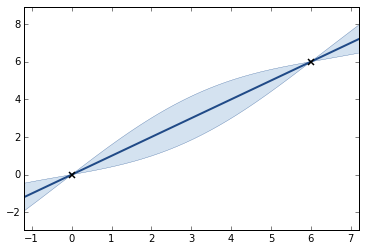

In [104]:
regPrior = registrationPrior(0,6)
regPrior.plot()

In [105]:
regPrior

GP_regression.,Value,Constraint,Prior,Tied to
linmap.A,[ 1.],fixed,,
rbf.variance,1.0,+ve,,
rbf.lengthscale,3.0,+ve,,
Gaussian_noise.variance,1e-06,+ve,,


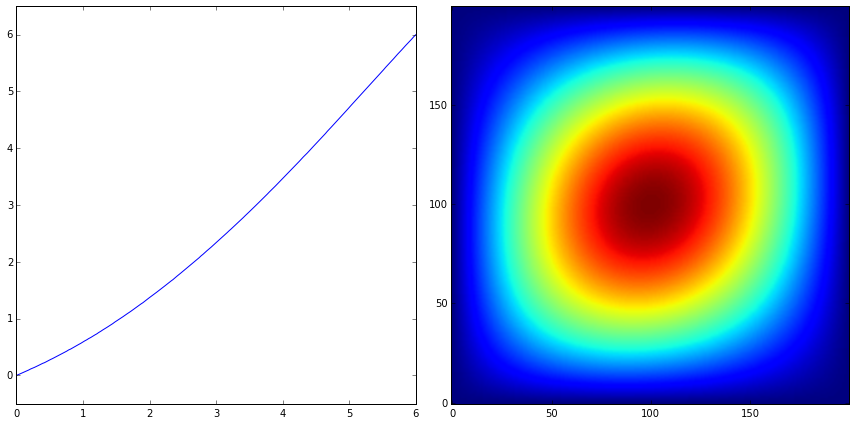

In [106]:
t = np.linspace(0,6,200)
mu,cov = regPrior.predict(t[:,None],full_cov=True)
sample = scipy.stats.multivariate_normal.rvs(mu[:,0],cov)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(t,sample)
plt.ylim(np.min(sample)-.5,np.max(sample)+.5)

plt.subplot(122)
plt.imshow(cov,origin=0)

plt.tight_layout()